In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from data import spectra_paths, bran_z, bran_disc
import pandas as pd
import os
import numpy as np
from astropy.time import Time
from plots import big_fontsize, fig_width, fontsize

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{romanbar}')

<ipython-input-4-1ab9cdcb70ad>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(path, names=["wl", "flux"], sep="  ", index_col=None)
<ipython-input-4-1ab9cdcb70ad>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower["flux"] /= np.mean(lower["flux"])
<ipython-input-4-1ab9cdcb70ad>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

                wl          flux
0      3201.274505  4.241250e-16
1      3203.277914  3.962632e-16
2      3205.281762  4.042828e-16
3      3207.286050  4.350775e-16
4      3209.290776  3.905521e-16
...            ...           ...
4874  10290.119825  8.777963e-17
4875  10291.304884  9.233637e-17
4876  10292.489921  8.598726e-17
4877  10293.674937  8.725743e-17
4878  10294.859932  8.106105e-17

[4879 rows x 2 columns]


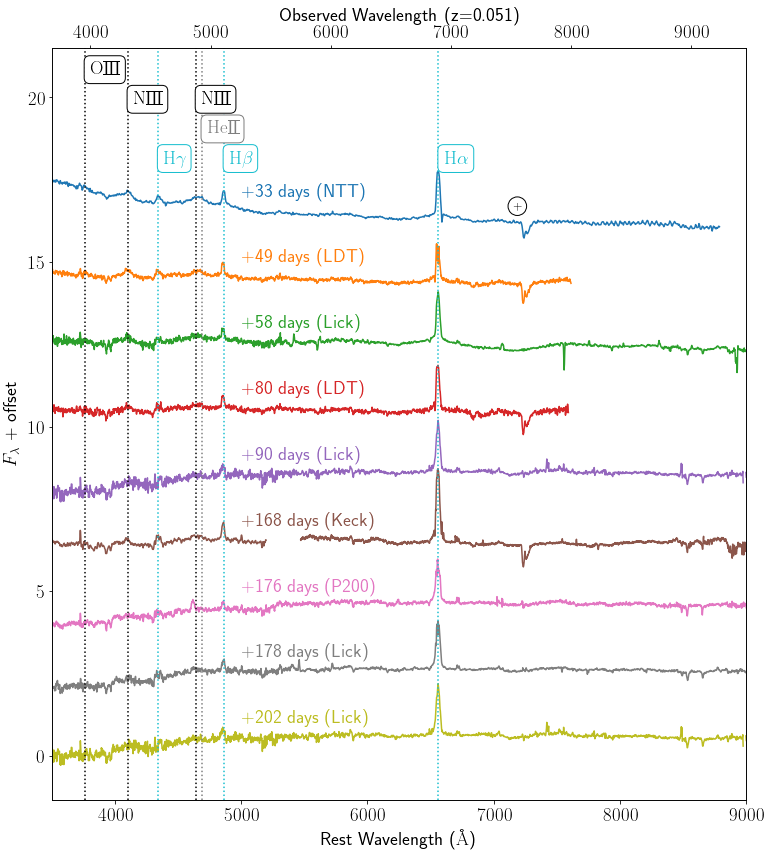

In [4]:
exp_times = {
    "ZTF19aapreis_20190513_NTT_v1.ascii": 900, # From TNS
    "ZTF19aapreis_20191003_P200_v1.ascii": 1450
}

redshift = 1 + bran_z


plt.figure(figsize=(1.8*fig_width, 2*fig_width))
ax1 = plt.subplot(111)
j = 0

# Redo with actual numbers, not Robert-on-train-reads-off-plot

cols = ["C9", "C7", "k", "k"]
# cols = [":", "--", "-.", "-"]

lines = [
    (r"$\rm{H\alpha}$", 6562.8, 0),
    (r"$\rm{H\beta}$", 4861, 0),
    (r"$\rm{H\gamma}$", 4340, 0),
    (r"$\rm{He\Romanbar{II}}$", 4686, 1),
    (r"$\rm{N\Romanbar{III}}$", 4640, 2),
    (r"$\rm{N\Romanbar{III}}$", 4100, 2),
    (r"$\rm{O\Romanbar{III}}$", 3760, 3)
]

for path in spectra_paths:
    name = os.path.basename(path).split("_")
    vetos = ["P60"]
    
    raw_date = name[1]
    date = Time(f"{raw_date[:4]}-{raw_date[4:6]}-{raw_date[6:]}T00:00:00.00", format='isot', scale='utc')
    n_days = date.mjd - bran_disc.mjd
    
    if np.sum([x in name for x in vetos]) == 0:
        
        if "ascii" in path:
            data = pd.read_table(path, names=["wl", "flux", "flux_err"], sep=" ", comment='#')
        else:
            data = pd.read_csv(path, names=["wl", "flux"], sep="  ", index_col=None)

        mask = data["flux"] > 0.
        data[~mask] = np.nan
        
        if np.sum(~mask) == 1.:
            index = list(mask).index(0)
            lower = data[:index]
            upper = data[index:]
            lower["flux"] /= np.mean(lower["flux"])
            upper["flux"] /= np.mean(upper["flux"])

            lower["flux"] *= upper["flux"].iloc[1]/lower["flux"].iloc[-1]
        
        label = f"+{n_days:.0f} days ({name[2][:4]})"
        y_pos = 15.5 - float(j)
        
        plt.plot(data["wl"]/redshift, y_pos + data["flux"]/np.mean(data["flux"]), label=label)
        plt.annotate(label, (5000., y_pos + 1.5), color=f"C{int(j/2)}", fontsize=big_fontsize)
        j += 2.0
# plt.yscale("log")
# plt.legend(fontsize=big_fontsize)

for (label, wl, col) in lines:
    plt.axvline(wl, linestyle=":", color=cols[col])
    
    bbox = dict(boxstyle="round", fc="white", ec=cols[col])
    
    plt.annotate(label, (wl + 40., 18.0 + 0.9*col), fontsize=big_fontsize, bbox=bbox, color=cols[col])
    
bbox = dict(boxstyle="circle", fc="white", ec="k")

plt.annotate("+", (7150., 16.6), fontsize=fontsize, bbox=bbox, color=cols[col])

plt.ylabel(r"$F_{\lambda}$ + offset", fontsize=big_fontsize)
ax1.set_ylim(top=21.5)
ax1b = ax1.twiny()
ax1.set_xlim(left=3500, right=9000)
rslim = ax1.get_xlim()
ax1b.set_xlim((rslim[0] * redshift, rslim[1] * redshift))
ax1.set_xlabel(r"Rest Wavelength ($\rm \AA$)", fontsize=big_fontsize)
ax1b.set_xlabel(rf"Observed Wavelength (z={bran_z:.3f})", fontsize=big_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=big_fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.tight_layout()
plt.savefig("plots/spectra.pdf")
plt.show()